# Формирование модели монетизации

## Описание данных:

Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

Датасет *ad_cost.csv* содержит колонки:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов


Датасет user_source.csv содержит колонки:

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

Задачи:
- Сформировать модель монетизации:
  - Провести исследовательский анализ данных
  - Проанализировать влияние событий на совершение целевого события
  - Проверить статистические гипотезы

In [1]:
#pip install -U seaborn

In [2]:
import pandas as pd
import seaborn as sns
import datetime as dt
import plotly.express as px
import matplotlib.pyplot as plt

from scipy import stats as st
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

# Отображать до 150 символов в ячейках таблицы:
pd.set_option('display.max_colwidth', 150)

# Отображать все столбцы в таблицах:
pd.set_option('display.max_columns', None)

In [3]:
#path = 'C:/Users/K/Desktop/F/'
path = '/datasets/'
game_actions = pd.read_csv(path + 'game_actions.csv')
ad_costs = pd.read_csv(path + 'ad_costs.csv')
user_source = pd.read_csv(path + 'user_source.csv')

## Просмотр и предобработка данных

In [4]:
# Просмотрим содержимое, типы данных и количество пропусков в датасетах: 
def views(data):
    display(data.head(2))
    data.info()

views(game_actions)
views(ad_costs)
views(user_source)

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null object
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: object(5)
memory usage: 5.2+ MB


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null object
cost      28 non-null float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
user_id    13576 non-null object
source     13576 non-null object
dtypes: object(2)
memory usage: 212.2+ KB


Вывод: Поля `event_datetime` и 'day' имеют тип object. Пропущенные значения в столбцах - 'building_type', и 'project_type'. 

In [5]:
# Приводим столбцы с датами к типу - datetime64:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
ad_costs['day'] = pd.to_datetime(ad_costs['day'])

# Проверим:
display(game_actions.dtypes)
display(ad_costs.dtypes)

# Дополнительное решение:
#orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

event_datetime    datetime64[ns]
event                     object
building_type             object
user_id                   object
project_type              object
dtype: object

source            object
day       datetime64[ns]
cost             float64
dtype: object

Вывод: Заменили тип данных в столбцах `event_datetime` и 'day' на datetime64.

In [6]:
# Посмотрим категориальные переменные:
def category(data, col):
    display(data[col].value_counts().reset_index())

# Вызов функции:
category(game_actions, 'event')
category(game_actions, 'building_type')
category(game_actions, 'project_type')
category(ad_costs, 'source')
category(user_source, 'source')

# Просмотрим диапазон дат событий в game_actions:
display("Минимальная дата событий game_actions: " + str(game_actions['event_datetime'].min()))
display("Максимальная дата событий game_actions: " + str(game_actions['event_datetime'].max()))
display("-----------------------------------------------------------")
# Просмотрим диапазон дат в ad_costs:
display("Минимальная дата событий ad_costs: " + str(ad_costs['day'].min()))
display("Максимальная дата событий ad_costs: " + str(ad_costs['day'].max()))

,index,event
0,building,127957
1,finished_stage_1,5817
2,project,1866


,index,building_type
0,spaceport,59325
1,assembly_shop,54494
2,research_center,14138


,index,project_type
0,satellite_orbital_assembly,1866


,index,source
0,yandex_direct,7
1,instagram_new_adverts,7
2,facebook_ads,7
3,youtube_channel_reklama,7


,index,source
0,yandex_direct,4817
1,instagram_new_adverts,3347
2,facebook_ads,2726
3,youtube_channel_reklama,2686


'Минимальная дата событий game_actions: 2020-05-04 00:00:01'

'Максимальная дата событий game_actions: 2020-06-05 12:32:49'

'-----------------------------------------------------------'

'Минимальная дата событий ad_costs: 2020-05-03 00:00:00'

'Максимальная дата событий ad_costs: 2020-05-09 00:00:00'

Вывод: Категориальные переменные соответствуют названиям столбцов. Диапазон событий в `game_actions` находится в пределах дат с 2020-05-04 по 2020-06-05. Диапазон событий в `ad_costs` находится в пределах дат с 2020-05-03 
по 2020-05-09.

In [7]:
# Просмотрим дубли:
display("Всего дублей: " + str(game_actions.duplicated().sum()))

# Выведем все дуюлирующиеся записи:
display(game_actions[game_actions[['event_datetime','event', 'building_type', 'user_id']].duplicated(keep=False)].sort_values('user_id'))

# Удалим дубль:
game_actions.drop_duplicates(inplace=True)

# Проверим количество дублей:
display("Всего дублей: " + str(game_actions[['event_datetime','event', 'building_type', 'user_id']].duplicated().sum()))

# Посчитаем количество пользователей:
total_users = game_actions['user_id'].nunique()
display("Всего пользователей: " + str(total_users))

'Всего дублей: 1'

,event_datetime,event,building_type,user_id,project_type
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN


'Всего дублей: 0'

'Всего пользователей: 13576'

Вывод: Удалили один дубль. Общее количество пользователей - 13576.

In [8]:
# Посмотрим на распределение пропусков в столбце - building_type и project_type, в зависимости от события - event:
game_actions.groupby('event').count()

,event_datetime,building_type,user_id,project_type
event,,,,
building,127956,127956,127956,0
finished_stage_1,5817,0,5817,0
project,1866,0,1866,1866


Вывод: Пропуски в столбце `building_type` присутствуют только в строках событий 'finished_stage_1' и 'project', наименование зданий в этих строках не предполагается. Пропуски в project_type - находятся по причине, того что в данных существует только один тип проекта - 'satellite_orbital_assembly' и приходится он только на записи в событиях `event` которых установленно 'project', в строках событий 'finished_stage_1' и 'project', наименование зданий не предполагается. Пропуски не удаляем.

In [9]:
# Добавим дату события в датафрейм game_actions для дальнейших расчетов:
game_actions['date'] = game_actions['event_datetime'].dt.date # выделим дату
game_actions['date'] = pd.to_datetime(game_actions['date'])   # приведем к формату - datetime64

# Добавим первый игровой день в датафрейм game_actions:
first_game_day = game_actions.groupby(['user_id'])['date'].min()
first_game_day.name = 'first_game_day'

# Присоединим 'first_game_day' к датафрейму game_actions:
game_actions = game_actions.join(first_game_day, on='user_id')
game_actions.info()
display(game_actions)

# Проверим на пользователе:
display(game_actions[game_actions['user_id']=='55e92310-cb8e-4754-b622-597e124b03de'])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 7 columns):
event_datetime    135639 non-null datetime64[ns]
event             135639 non-null object
building_type     127956 non-null object
user_id           135639 non-null object
project_type      1866 non-null object
date              135639 non-null datetime64[ns]
first_game_day    135639 non-null datetime64[ns]
dtypes: datetime64[ns](3), object(4)
memory usage: 8.3+ MB


,event_datetime,event,building_type,user_id,project_type,date,first_game_day
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,2020-05-04
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04,2020-05-04
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04,2020-05-04
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04,2020-05-04
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04,2020-05-04
...,...,...,...,...,...,...,...
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN,2020-06-05,2020-05-06
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,2020-06-05,2020-05-07
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN,2020-06-05,2020-05-07
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN,2020-06-05,2020-05-07


,event_datetime,event,building_type,user_id,project_type,date,first_game_day
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,2020-05-04
10101,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04
15489,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04
16114,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04
17607,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-06,2020-05-04
42109,2020-05-08 08:16:51,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-08,2020-05-04
76040,2020-05-10 20:27:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-10,2020-05-04


In [10]:
# Сопоставим каждому пользователю источник с которого он пришел:
game_actions = game_actions.merge(user_source, on='user_id')
display(game_actions.head(10))

,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,2020-05-04,youtube_channel_reklama
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04,youtube_channel_reklama
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04,youtube_channel_reklama
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04,youtube_channel_reklama
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-06,2020-05-04,youtube_channel_reklama
5,2020-05-08 08:16:51,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-08,2020-05-04,youtube_channel_reklama
6,2020-05-10 20:27:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-10,2020-05-04,youtube_channel_reklama
7,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04,2020-05-04,facebook_ads
8,2020-05-06 23:49:25,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-06,2020-05-04,facebook_ads
9,2020-05-07 03:56:30,building,spaceport,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-07,2020-05-04,facebook_ads


Вывод: Добавили столбцы даты события и даты первого события(день первой игры), сопоставили пользователям исчточники трафика по которым они пришли.

## Исследовательский анализ данных

### Определение количества построенных объектов и совершенных событий по дням

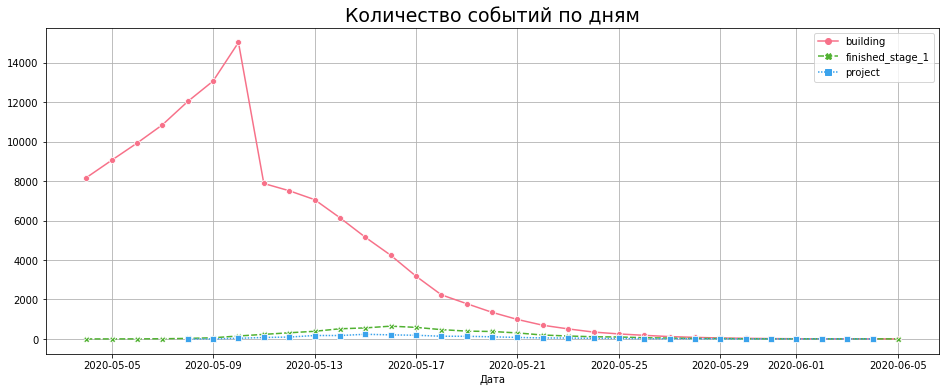

In [11]:
# Построим графики количества объектов и событий по дням:
total_events = game_actions.pivot_table(index='date', columns='event', values='user_id', aggfunc='count')

# Строим графики:
plt.figure(figsize=(16,6))
g=sns.lineplot(data = total_events, palette="husl", markers=True)
plt.title('Количество событий по дням', fontsize=19)
g.set_xlabel("Дата")
g.grid(True)
plt.show()

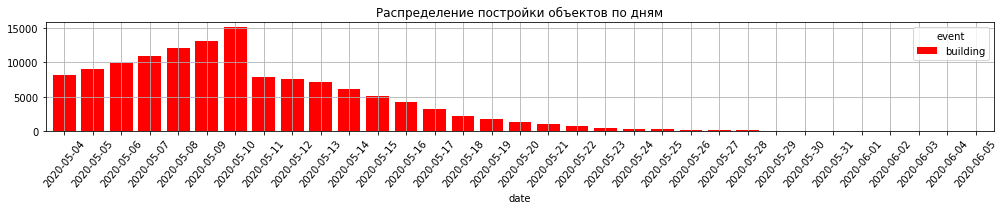

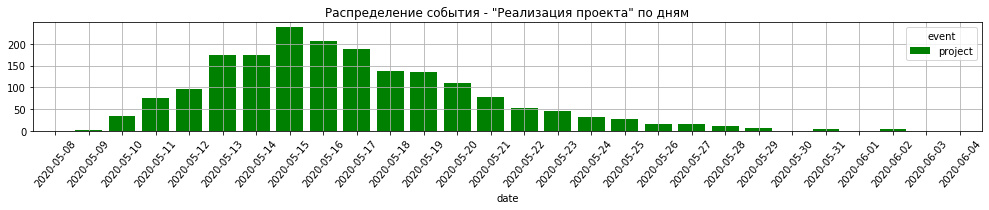

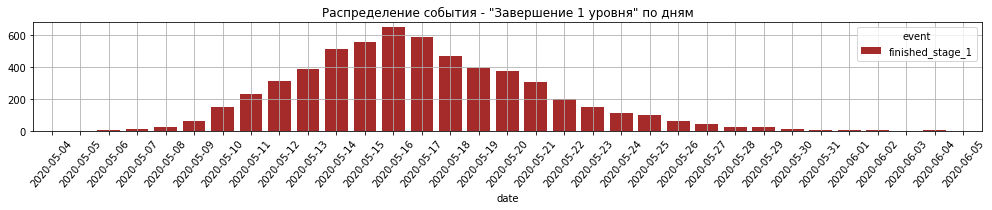

In [12]:
# Гистограммы количества событий по дням:
# Так как в датасете присутствует 3 события создадим функцию для отрисовки графиков:
def displayhist(type_event, color, title):
    dt = game_actions[game_actions['event'] == type_event]
    dt['date'] = dt['date'].astype('str')    
    dt = dt.pivot_table(index='date', columns='event', values='user_id', aggfunc='count')
        
    dt.plot(kind = 'bar', figsize=(17,2), width = 0.8, color=color, title=title)
    plt.xticks(rotation=50)
    plt.grid(True)
    plt.show()

# Вызываем функцию постройки гистограмм:
displayhist('building', 'red', 'Распределение постройки объектов по дням')
displayhist('project', 'green', 'Распределение события - "Реализация проекта" по дням')
displayhist('finished_stage_1', 'brown', 'Распределение события - "Завершение 1 уровня" по дням')

Вывод: На графиках заметно значительно меньшее количество событий (project и finished_stage1) по дням в сравнении с количеством событий - building. Потому что событие projec необходимо выполнение определенной последовательности событий, т.е. присутствует более сложная и растянутое по времени последовательность действий нежели для события building, которое может включать в себя любую постройку из трех типов объектов. События пики событий building, project, finished_stage1 смещены на графиках друг относительно друга на несколько дней это обусловлено игровой механикой, т.е сперва идет постройка зданий, затем (как возможное одно из условий достижения победы) реализация проекта и затем фиксируется прохождение 1 уровня событием - finished_stage1. На линейном графике и гистограмме события building - заметно резкое снижение числа событий с 10 на 11 число это обусловлено существенным спадом привлечения новых пользователей в игру.

building_type,assembly_shop,research_center,spaceport
date,,,
2020-05-04,7767.0,NaN,403.0
2020-05-05,7816.0,NaN,1236.0
2020-05-06,7736.0,5.0,2180.0
2020-05-07,7775.0,31.0,3041.0
2020-05-08,7833.0,123.0,4074.0
2020-05-09,7698.0,368.0,5000.0
2020-05-10,7869.0,863.0,6290.0
2020-05-11,NaN,1291.0,6585.0
2020-05-12,NaN,1540.0,5969.0


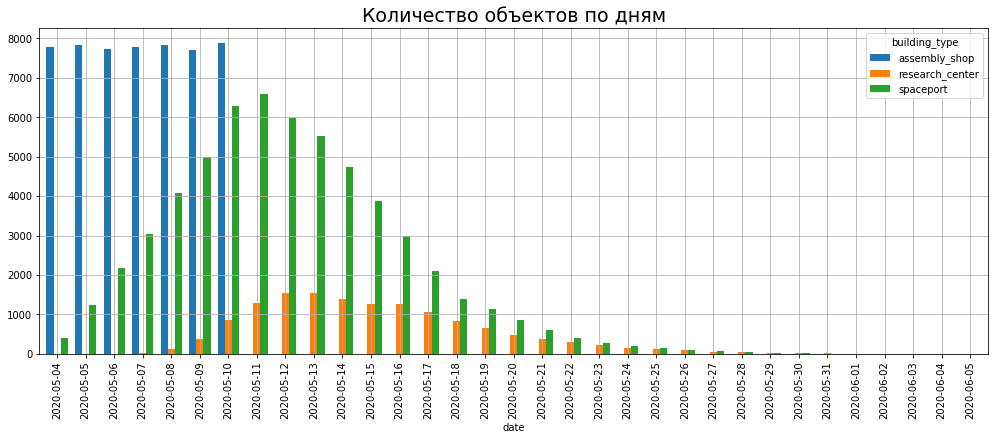

In [13]:
# Построим столбчатую диаграмму - количество построенных объектов по дням:
total_buildings = game_actions.copy()
total_buildings['date'] = total_buildings['date'].astype('str')
total_buildings = total_buildings.pivot_table(index='date', columns='building_type', values='user_id', aggfunc='count')
display(total_buildings)

# Построим график:
total_buildings.plot(grid='True', kind='bar', figsize=(17,6), width = 0.75)
plt.title('Количество объектов по дням', fontsize=19)
g.set_xlabel("Дата")
g.grid(True)
plt.show()

Вывод: Графике в первую очередь заметно последовательность постройки объектов - assembly_shop, research-center, spaceport, позже мы выясним какие последовательности строительства объектов встречаются в игре. Пик построек так же как и на предыдущих графиках событий приходится на 10-11 числа. Особенно выделяется высокие значения ~ 8000 количества построек assembly_shop. Приходятся они все на начало привлечения пользователей в игру 4-10 числа месяца. Здесь возможны несколько причин: пользователям необходимо больше некоторых ресурсов для получения доступа к другим постройкам, возможно им не очень понятно что нужно делать в игре, но на лицо игровой дисбаланс, дополнительно выяснить у авторов игры всю механику и обратить на это внимание.

### Определение доли пользователей по способу прохождения 1 уровня.

In [14]:
# Создадим отдельный датафрейм уникальных пользователей и список событий, которые пользователь совершил.
game = game_actions.groupby('user_id')['event'].apply(lambda x: x.unique()).reset_index()

# Переименуем столбец:
game = game.rename(columns={'event':'unique_events'})

# Присвоим каждому пользователю способ прохождения первого уровня в зависимости от набора уникальных значений событий - 'unique_events':
game['win_status'] = game['unique_events'].map(lambda x: "project_win" if ['project'] in x else "enemy_defeated" if ['building' and 'finished_stage_1'] in x else "not_win")

# Посчитаем количество пользователей по способу прохождения первого уровня - win_status:
winners_proportion = game.pivot_table(index='win_status', values='user_id', aggfunc='count').reset_index()

# Определим доли пользователей прошедших и не прошедших 1 уровень:
winners_proportion['_%'] = round(winners_proportion['user_id']*100/total_users, 2)

display(game.sample(3))
display(winners_proportion)

,user_id,unique_events,win_status
10515,c667b3fe-e9a9-4769-ba6a-19386a6008de,[building],not_win
9898,bb075d19-6c1c-48fb-b10d-2a06ec637093,[building],not_win
11475,d8e656d3-cb29-4ba3-8de3-90b1d21457fd,[building],not_win


,win_status,user_id,_%
0,enemy_defeated,3951,29.10
1,not_win,7759,57.15
2,project_win,1866,13.74


In [15]:
# Соединим таблицу содержащую статус прохождения 1 уровня - game c основной таблицей - game_actions:

# Создадим новый датафрейм - data:
data = pd.merge(game_actions, game, on='user_id')
display(data.sample(2))

,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source,unique_events,win_status
69573,2020-05-10 12:28:09,building,spaceport,8cd92e81-ea87-4b78-85ce-459f162591b9,NaN,2020-05-10,2020-05-05,yandex_direct,"[building, project, finished_stage_1]",project_win
129774,2020-05-09 16:53:07,building,assembly_shop,88ec0e28-2a94-456f-9a82-ad6bce5efe38,NaN,2020-05-09,2020-05-08,yandex_direct,"[building, finished_stage_1]",enemy_defeated


Вывод: Если у пользователя есть только событие building, то присвоим статус- not_win, если к этому событию добавляется событие - finished_stage1, то присваиваем статус - enemy_defeated(победа над врагом), если у пользователя есть еще и событие - project - то присваиваем ему статус - project_win(победа - реализацией проекта). По итогу доля пользователей прошедших 1 уровень ~ 43%, пользователи не прошедшие 1 уровень составляют - 57%.

### Определение последовательности постройки зданий

In [16]:
# Создадим датафрейм который содержит очередность постройки зданий для каждого игрока:
# Используем метод - unique(), который возвращает элементы в порядке их появления:
build_order = data.groupby('user_id')['building_type'].unique().reset_index()

# Переводим полученный список (столбец - building_type) в строку (столбец - building_order):
# Конструкция - " ".join() в коде собирает элементы списка в одну строку через пробел:
build_order['building_order'] = build_order['building_type'].apply(lambda x: " ".join(str(item) for item in x))

# Удалим из строки очередности постройки, содержащие часть " nan":
build_order['building_order'] = build_order['building_order'].apply(lambda x: x.replace(' nan', ""))
display(build_order.sample(3))

# Удалим столбец - building_type:
build_order.drop('building_type', axis=1, inplace=True)

display(build_order.sample(3))

# Посчитаем количество пользователей с каждой последовательностью постройки объектов:
display(build_order.groupby('building_order').count().reset_index())

# Дополнительно:
#build_order['lis'] = build_order['building_type'].str.contains('assembly_shop')

,user_id,building_type,building_order
8486,a00f646e-cb19-4143-b657-9c05e6bf097c,"[assembly_shop, spaceport]",assembly_shop spaceport
11999,e236f46f-7edd-435b-b187-90d35b455dc4,"[assembly_shop, spaceport, nan]",assembly_shop spaceport
12734,f006efc1-c597-42e6-a37c-c47ee4f881bf,"[assembly_shop, nan]",assembly_shop


,user_id,building_order
8787,a55b03a0-aa5c-48a4-a6e5-e4f32bdc7055,assembly_shop spaceport research_center
7266,87c5106c-b4f1-46fa-bf84-37044a3f4d51,assembly_shop spaceport
10048,be28241a-f363-4bd7-8775-5a22f913e8aa,assembly_shop spaceport research_center


,building_order,user_id
0,assembly_shop,345
1,assembly_shop research_center spaceport,86
2,assembly_shop spaceport,5560
3,assembly_shop spaceport research_center,7585


Вывод: Наиболее преобладающей последовательностью постройки объектов является - (assembly_shop spaceport research_center) - количество пользователей 7585. Что соответствует графику рассмотренному выше (Столбчатая диаграмма - количество построенных объектов по дням). Наименее преобладающей последовательность является - (assembly_shop research_center spaceport) - количество пользователей - 86.

In [17]:
# Соединим полученную информацию в один датафрейм и проверим на одном пользователе:

# Соединим полученную таблицу (build_order) содержащую последовательность постройки зданий с основной(data):
data_merge2 = pd.merge(data, build_order, on='user_id')
display(data_merge2.sample(2))

# Проверим на пользователе очередность построенных зданий:
display(data_merge2[data_merge2['user_id'] == 'ea70ca49-3c0e-45a7-ac72-d1e1f7407ad9'])

,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source,unique_events,win_status,building_order
132823,2020-05-14 03:34:54,building,spaceport,3f868abb-da2d-4fcd-909d-048604f1f61f,NaN,2020-05-14,2020-05-09,instagram_new_adverts,[building],not_win,assembly_shop spaceport
72747,2020-05-09 07:04:06,building,assembly_shop,81fac0a1-fb17-4d48-90fe-50dc5e9ae5ab,NaN,2020-05-09,2020-05-05,facebook_ads,"[building, project, finished_stage_1]",project_win,assembly_shop spaceport research_center


,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source,unique_events,win_status,building_order
13778,2020-05-04 04:03:38,building,assembly_shop,ea70ca49-3c0e-45a7-ac72-d1e1f7407ad9,NaN,2020-05-04,2020-05-04,youtube_channel_reklama,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport research_center
13779,2020-05-04 13:16:37,building,assembly_shop,ea70ca49-3c0e-45a7-ac72-d1e1f7407ad9,NaN,2020-05-04,2020-05-04,youtube_channel_reklama,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport research_center
13780,2020-05-08 00:27:33,building,assembly_shop,ea70ca49-3c0e-45a7-ac72-d1e1f7407ad9,NaN,2020-05-08,2020-05-04,youtube_channel_reklama,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport research_center
13781,2020-05-08 22:31:48,building,assembly_shop,ea70ca49-3c0e-45a7-ac72-d1e1f7407ad9,NaN,2020-05-08,2020-05-04,youtube_channel_reklama,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport research_center
13782,2020-05-09 00:51:28,building,assembly_shop,ea70ca49-3c0e-45a7-ac72-d1e1f7407ad9,NaN,2020-05-09,2020-05-04,youtube_channel_reklama,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport research_center
13783,2020-05-10 00:11:02,building,assembly_shop,ea70ca49-3c0e-45a7-ac72-d1e1f7407ad9,NaN,2020-05-10,2020-05-04,youtube_channel_reklama,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport research_center
13784,2020-05-10 15:18:41,building,spaceport,ea70ca49-3c0e-45a7-ac72-d1e1f7407ad9,NaN,2020-05-10,2020-05-04,youtube_channel_reklama,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport research_center
13785,2020-05-12 15:42:08,building,spaceport,ea70ca49-3c0e-45a7-ac72-d1e1f7407ad9,NaN,2020-05-12,2020-05-04,youtube_channel_reklama,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport research_center
13786,2020-05-15 14:09:21,building,research_center,ea70ca49-3c0e-45a7-ac72-d1e1f7407ad9,NaN,2020-05-15,2020-05-04,youtube_channel_reklama,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport research_center
13787,2020-05-17 07:35:40,building,spaceport,ea70ca49-3c0e-45a7-ac72-d1e1f7407ad9,NaN,2020-05-17,2020-05-04,youtube_channel_reklama,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport research_center


### Определение количества построенных зданий по статусу прохождения 1 уровня

building_type,win_status,assembly_shop,research_center,spaceport
0,enemy_defeated,16298,3755,17132
1,not_win,29080,6685,31405
2,project_win,9116,3697,10788


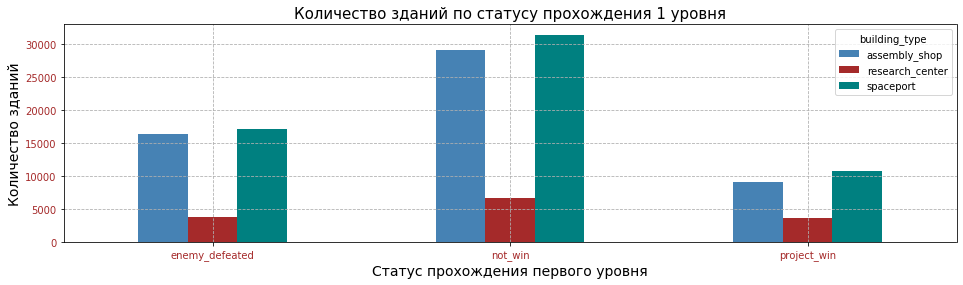

In [19]:
# Построим сводную таблицу:
building_by_win_status_bar = data_merge2.pivot_table(index='win_status', columns='building_type', values='event', aggfunc='count').reset_index()
display(building_by_win_status_bar)

# Построим столбчатую диаграмму:
ax = building_by_win_status_bar.plot.bar(figsize=(16,4), color=['#4682B4', '#A52A2A', '#008080'], x='win_status', grid=True)
plt.title("Количество зданий по статусу прохождения 1 уровня", size=15)
plt.ylabel("Количество зданий", size=14)
plt.yticks(color='brown')
plt.xlabel("Статус прохождения первого уровня", size=14)
plt.xticks(color='brown', rotation='horizontal')
plt.grid(True, linestyle=('--'))
plt.show()

Вывод: На графике видно, что пропорции количества построенных зданий для каждого статуса победы сходны, т.е. больше всего строят spaceport, затем assembly_shop(не значительно отстает от кол-ва построек spaceport). И в несколько раз меньше строят - research _center. Пользователи прошедшие первый уровень - реализацией проекта строят меньше всего зданий, пользователи не прошедшие 1 уровень строят больше всех. Здесь видимо причина может быть в то, что пользователи не знают что нужно сделать для победы. Нужно сообщить разработчикам о улучшении этапа обучения для пользователей.

building_type,assembly_shop,research_center,spaceport
win_status,,,
enemy_defeated,16298,3755,17132
not_win,29080,6685,31405
project_win,9116,3697,10788


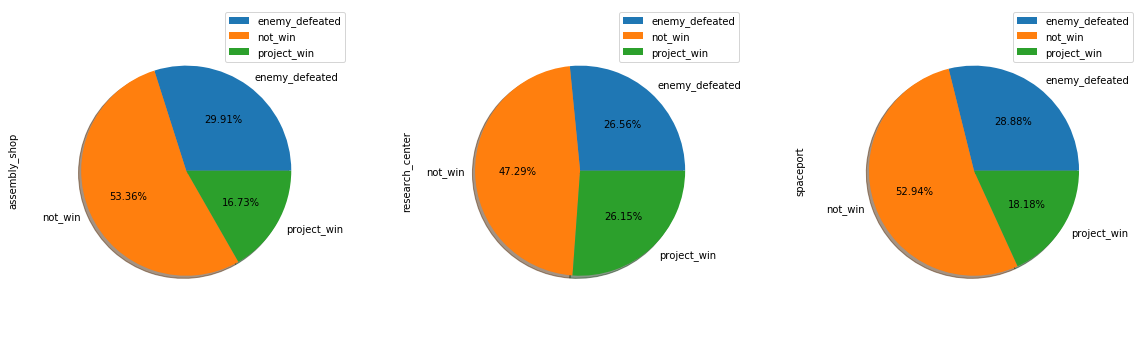

In [20]:
# Отобразим пропорции на круговых диаграммах:
building_by_win_status_pie = data_merge2.pivot_table(index='win_status', columns='building_type', values='event', aggfunc='count')
display(building_by_win_status_pie)
# Построим столбчатую диаграмму:

plot = building_by_win_status_pie.plot.pie(subplots=True, figsize=(20, 7), radius=0.8, autopct='%1.2f%%', shadow = True)
plt.show()

building_order,assembly_shop,assembly_shop research_center spaceport,assembly_shop spaceport,assembly_shop spaceport research_center
win_status,,,,
enemy_defeated,289.0,353.0,11704.0,24839.0
not_win,1068.0,421.0,24244.0,41437.0
project_win,NaN,210.0,NaN,23391.0


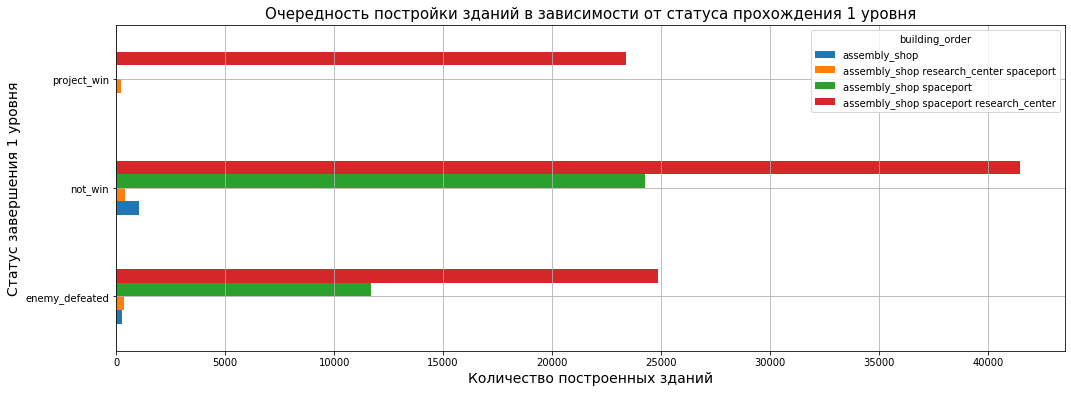

In [21]:
# Посмотрим какая очередность постройки зданий фигугрирует у пользователей в зависимости от статуса прохождения 1 уровня - 'win_status':
pivot_data_merge2 = data_merge2.pivot_table(index='win_status', columns='building_order', values='building_type', aggfunc='count')
display(pivot_data_merge2)

pivot_data_merge2.plot(grid=True, kind='barh', figsize=(17,6))
plt.title('Очередность постройки зданий в зависимости от статуса прохождения 1 уровня', size=15)
plt.xlabel("Количество построенных зданий", size=14)
plt.ylabel("Статус завершения 1 уровня", size=14)
plt.show()

Вывод: Последовательность - 'assembly_shop spaceport research_center' является превосходящей для всех статусов прохождения 1 уровня. Но пользователи завершившие реализацией проекта это последовательность представляется практически единственной.

### Распределение событий(постройка объектов) по статусу прохождения 1-го уровня:

,user_id,win_status,building_type,event
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,not_win,assembly_shop,6
1,0001f83c-c6ac-4621-b7f0-8a28b283ac30,not_win,research_center,1
2,0001f83c-c6ac-4621-b7f0-8a28b283ac30,not_win,spaceport,6
3,00151b4f-ba38-44a8-a650-d7cf130a0105,not_win,assembly_shop,4
4,00151b4f-ba38-44a8-a650-d7cf130a0105,not_win,spaceport,5
...,...,...,...,...
34473,ffff194a-56b7-4c12-860d-3485242ae7f5,not_win,assembly_shop,6
34474,ffff194a-56b7-4c12-860d-3485242ae7f5,not_win,spaceport,1
34475,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,project_win,assembly_shop,3
34476,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,project_win,research_center,3


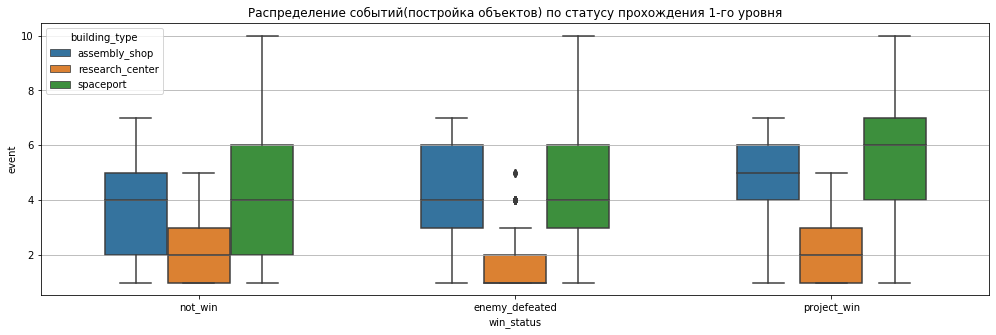

In [22]:
# Построим boxplot количества событий для статуса завершения 1 уровня:
bx = data_merge2.pivot_table(index =['user_id','win_status', 'building_type'], values='event', aggfunc='count').reset_index()
display(bx)

# Построим boxplot:
plt.figure(figsize=(17,5))
plt.grid(True)
ax = sns.boxplot(x='win_status', y='event', hue='building_type', data=bx, width=0.6, saturation=0.7)
plt.title('Распределение событий(постройка объектов) по статусу прохождения 1-го уровня')
plt.show()

Вывод: В основном пользователи строят от 3 до 6 зданий assembly_shop spaceport, а  research_center  от 1 до 3 на пользователя по всем статусам прохождения 1 уровня.

### Определим за сколько дней пользователи проходят уровень:

In [23]:
# Выберем пользователей, которые завершили 1 уровень:
finished_stage_users = data_merge2[data_merge2['event']=='finished_stage_1']

# Выберем только столбцы - 'user_id','date':
finished_stage_users = finished_stage_users[['user_id','date']]

# Переименуем столбец 'date' на 'finished_stage_1_date''
finished_stage_users = finished_stage_users.rename(columns={'date':'finished_stage_1_date'})

display(finished_stage_users.head(2))

# Соединим таблицу с датами завершения 1 ур. с основной таблицей - data_merge2:
data_merge3 = pd.merge(data_merge2, finished_stage_users, how='left', on='user_id')
display(data_merge3.sample(1))

# Вычислим сколько дней уходит у пользователя чтобы завершить 1 уровень:
data_merge3['days_to_win'] = data_merge3['finished_stage_1_date'] - data_merge3['first_game_day']

# Переведем значения столбца 'days_to_win' во float64:
data_merge3['days_to_win'] = data_merge3['days_to_win'] / np.timedelta64(1, 'D')

display(data_merge3.sample(1))

# Проверим на пользователе:
display(data_merge3[data_merge3['user_id']=='226cd37d-493c-4364-b07c-74aa3ad0b167'])

,user_id,finished_stage_1_date
19,c07b1c10-f477-44dc-81dc-ec82254b1347,2020-05-15
32,6edd42cc-e753-4ff6-a947-2107cd560710,2020-05-16


,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source,unique_events,win_status,building_order,finished_stage_1_date
9161,2020-05-07 10:45:33,building,assembly_shop,e860ebfa-a7f1-4c22-b605-cce405fa3fd4,NaN,2020-05-07,2020-05-04,youtube_channel_reklama,"[building, project, finished_stage_1]",project_win,assembly_shop spaceport research_center,2020-05-16


,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source,unique_events,win_status,building_order,finished_stage_1_date,days_to_win
78963,2020-05-05 08:16:13,building,assembly_shop,d06e9cd5-6693-4ce1-84df-6611642ba15f,NaN,2020-05-05,2020-05-05,facebook_ads,[building],not_win,assembly_shop spaceport research_center,NaT,NaN


,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source,unique_events,win_status,building_order,finished_stage_1_date,days_to_win
104109,2020-05-06 06:07:44,building,assembly_shop,226cd37d-493c-4364-b07c-74aa3ad0b167,NaN,2020-05-06,2020-05-06,instagram_new_adverts,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport,2020-05-13,7.0
104110,2020-05-09 00:52:26,building,assembly_shop,226cd37d-493c-4364-b07c-74aa3ad0b167,NaN,2020-05-09,2020-05-06,instagram_new_adverts,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport,2020-05-13,7.0
104111,2020-05-09 04:49:55,building,assembly_shop,226cd37d-493c-4364-b07c-74aa3ad0b167,NaN,2020-05-09,2020-05-06,instagram_new_adverts,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport,2020-05-13,7.0
104112,2020-05-09 20:57:39,building,spaceport,226cd37d-493c-4364-b07c-74aa3ad0b167,NaN,2020-05-09,2020-05-06,instagram_new_adverts,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport,2020-05-13,7.0
104113,2020-05-12 15:07:23,building,spaceport,226cd37d-493c-4364-b07c-74aa3ad0b167,NaN,2020-05-12,2020-05-06,instagram_new_adverts,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport,2020-05-13,7.0
104114,2020-05-13 12:01:42,finished_stage_1,NaN,226cd37d-493c-4364-b07c-74aa3ad0b167,NaN,2020-05-13,2020-05-06,instagram_new_adverts,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport,2020-05-13,7.0


win_status,days_to_win,enemy_defeated,project_win
0,0.0,3.0,NaN
1,1.0,43.0,NaN
2,2.0,102.0,NaN
3,3.0,186.0,NaN
4,4.0,418.0,NaN
5,5.0,691.0,27.0
6,6.0,1436.0,121.0
7,7.0,2515.0,282.0
8,8.0,3248.0,876.0
9,9.0,3923.0,1530.0


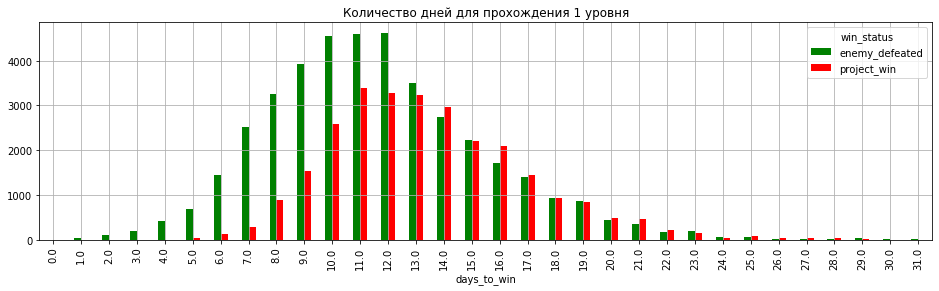

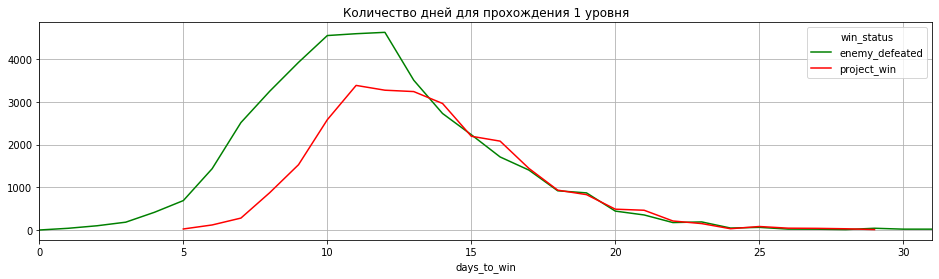

In [24]:
# Построим графики - количества дней до достижения победы по статусу победы:
# Построим сводную таблицу:
days_to_w = data_merge3.pivot_table(index='days_to_win', columns='win_status', values='user_id', aggfunc='count').reset_index()
display(days_to_w)

# Построим графики:
ax = days_to_w.plot.bar(figsize=(16,4), color=['green', 'red', 'blue'], x='days_to_win', grid=True, title='Количество дней для прохождения 1 уровня')
plt.show()

# То же самое - через линейный график:
ax = days_to_w.plot.line(figsize=(16,4), color=['green', 'red', 'blue'], x='days_to_win', grid=True,  title='Количество дней для прохождения 1 уровня')
plt.show()

Вывод: По двум гистограмам имеем скошенный вправо набор данных по двум статусам - реализация проекта и победа над врагом. Наиболее часто встречающееся количество дней необходимое для завершения 1 уровня находится в пределах от 7 до 16.

In [25]:
# Посчитаем среднее значение количества дней для прохождения 1 уровня в зависимости от статуса победы:
display(data_merge3.head(1))

display(data_merge3[data_merge3['win_status'] == 'enemy_defeated']['days_to_win'].mean())
display(data_merge3[data_merge3['win_status'] == 'project_win']['days_to_win'].mean())

,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source,unique_events,win_status,building_order,finished_stage_1_date,days_to_win
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,2020-05-04,youtube_channel_reklama,[building],not_win,assembly_shop,NaT,NaN


11.626847530143912

13.433322357589727

# Рассчитаем retention-rate когорт за неделю:

2020-05-04    135639
Name: first_activity_week, dtype: int64

,first_activity_week,cohort_lifetime,user_id,cohort_users,retention
0,2020-05-04,0,13576,13576,1.000000
1,2020-05-04,1,12121,13576,0.892826
2,2020-05-04,2,4353,13576,0.320639
3,2020-05-04,3,521,13576,0.038377
4,2020-05-04,4,29,13576,0.002136


cohort_lifetime,0,1,2,3,4
first_activity_week,,,,,
2020-05-04,1.0,0.892826,0.320639,0.038377,0.002136


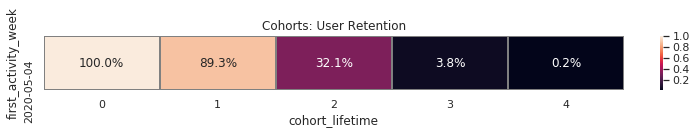

In [27]:
# Пояснение: В виду того, что у нас мобильное приложение, будем формирровать когорты по данным за неделю:
week_cohorts_data = data_merge2.copy()
week_cohorts_data.head(2)


week_cohorts_data['activity_week'] = pd.to_datetime(
    week_cohorts_data['date'], unit='d') - pd.to_timedelta(week_cohorts_data['date'].dt.dayofweek, unit='d')

week_cohorts_data['first_activity_week'] = pd.to_datetime(
    week_cohorts_data['first_game_day'], unit='d'
) - pd.to_timedelta(week_cohorts_data['first_game_day'].dt.dayofweek, unit='d') 

week_cohorts_data.sample(1)


display(week_cohorts_data['first_activity_week'].value_counts())


# Рассчитаем lifetime пользователя в пределах когорты:
week_cohorts_data['cohort_lifetime'] = week_cohorts_data['activity_week'] - week_cohorts_data['first_activity_week']
week_cohorts_data['cohort_lifetime'] = week_cohorts_data['cohort_lifetime'] / np.timedelta64(1, 'W')
week_cohorts_data['cohort_lifetime'] = week_cohorts_data['cohort_lifetime'].astype('int') 
week_cohorts_data.sample(1)


# Посчитаем количество на определенную неделю жизни:
cohorts = week_cohorts_data.groupby(['first_activity_week','cohort_lifetime']).agg({'user_id':'nunique'}).reset_index()
cohorts


# Для расчета retention-rate, найдем количество пользователей на нулевую неделю:
users_on_first_week = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_week', 'user_id']]
users_on_first_week = users_on_first_week.rename(columns={'user_id':'cohort_users'})

# Объединим исходные данные - 'user_activity' с 'users_on_first_week':
cohorts_merge = cohorts.merge(users_on_first_week, on='first_activity_week')
cohorts_merge


# Рассчитаем retention-rate и построим тепловую карту:
cohorts_merge['retention'] = cohorts_merge['user_id']/cohorts_merge['cohort_users']
display(cohorts_merge)

cohorts_merge['first_activity_week'] = cohorts_merge['first_activity_week'].astype('str')
cohorts_pivot = cohorts_merge.pivot_table(index='first_activity_week', columns='cohort_lifetime', values='retention', aggfunc='sum')
display(cohorts_pivot)


# Построим тепловую карту:
sns.set(style='white')
plt.figure(figsize=(13, 1))
plt.title('Cohorts: User Retention')
sns.heatmap(cohorts_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Вывод: Уже на второй недели наблюдается резкое падение до 32% возвращаемость пользователей и на четвертую неделю возвращаемость падает практически до 0.

### Расчет retention rate когорт по дням:

In [28]:
# Рассчитаем retention-rate когорт по дням:
# Будем работать с копией нашей итоговой таблицы - data_merge3:
day_cohorts_data = data_merge3.copy()
display(day_cohorts_data.head(2))

,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source,unique_events,win_status,building_order,finished_stage_1_date,days_to_win
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04,2020-05-04,youtube_channel_reklama,[building],not_win,assembly_shop,NaT,NaN
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-05,2020-05-04,youtube_channel_reklama,[building],not_win,assembly_shop,NaT,NaN


In [29]:
# Рассчитаем life_time:
day_cohorts_data['lifetime'] = day_cohorts_data['date'] - day_cohorts_data['first_game_day']
day_cohorts_data['lifetime'] = day_cohorts_data['lifetime']/np.timedelta64(1,'D')
day_cohorts_data['lifetime'] = day_cohorts_data['lifetime'].astype('int')
display(day_cohorts_data.sample(3))

,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source,unique_events,win_status,building_order,finished_stage_1_date,days_to_win,lifetime
48321,2020-05-07 18:27:00,building,assembly_shop,2a0d7bb1-eaef-4b8d-9f13-cd4e05691b11,NaN,2020-05-07,2020-05-04,facebook_ads,"[building, project, finished_stage_1]",project_win,assembly_shop spaceport research_center,2020-05-18,14.0,3
2284,2020-05-04 00:40:56,building,assembly_shop,b86dbbfa-1c2d-43eb-8c5a-746529c407ac,NaN,2020-05-04,2020-05-04,youtube_channel_reklama,[building],not_win,assembly_shop spaceport research_center,NaT,NaN,0
43022,2020-05-17 18:15:02,finished_stage_1,NaN,576d96ce-d4a1-47c3-b38a-680ad5326529,NaN,2020-05-17,2020-05-04,youtube_channel_reklama,"[building, project, finished_stage_1]",project_win,assembly_shop spaceport research_center,2020-05-17,13.0,13


In [30]:
# Посчитаем количество пользователей на определенный день:
cohorts = day_cohorts_data.groupby(['first_game_day','lifetime']).agg({'user_id':'nunique'}).reset_index()
display(cohorts)

# Рассчитаем изначальное количество пользователей в когорте:
init_users_cohort = cohorts[cohorts['lifetime']==0][['first_game_day', 'user_id']]
init_users_cohort = init_users_cohort.rename(columns={'user_id':'cohort_0_users'}) 
display(init_users_cohort)

# Объединяем данные по когортам с исходным количеством пользователей в когорте
cohorts_merge = cohorts.merge(init_users_cohort,on='first_game_day')
display(cohorts_merge)

# Рассчитаем retention-retention:
cohorts_merge['retention'] = cohorts_merge['user_id'] / cohorts_merge['cohort_0_users']
cohorts_merge['retention'] = cohorts_merge['retention'].round(2)
display(cohorts_merge)

#Для отображения на графике в строках когорт только даты прееобразуем 'first_game_day' в тип - str:
cohorts_merge['first_game_day'] = cohorts_merge['first_game_day'].astype('str')

retention_pivot = cohorts_merge.pivot_table(index='first_game_day', columns='lifetime', values='retention', aggfunc='sum')

# Выбираем часть датафрейма:
retention_pivot = retention_pivot.iloc[:, 1:26]

display(retention_pivot)

#
#retention_pivot = retention_pivot.iloc[0:6, 1:21]

,first_game_day,lifetime,user_id
0,2020-05-04,0,5860
1,2020-05-04,1,3021
2,2020-05-04,2,3204
3,2020-05-04,3,3412
4,2020-05-04,4,3564
...,...,...,...
194,2020-05-10,19,7
195,2020-05-10,20,3
196,2020-05-10,21,1
197,2020-05-10,22,1


,first_game_day,cohort_0_users
0,2020-05-04,5860
32,2020-05-05,3361
61,2020-05-06,1847
92,2020-05-07,1109
122,2020-05-08,688
149,2020-05-09,440
175,2020-05-10,271


,first_game_day,lifetime,user_id,cohort_0_users
0,2020-05-04,0,5860,5860
1,2020-05-04,1,3021,5860
2,2020-05-04,2,3204,5860
3,2020-05-04,3,3412,5860
4,2020-05-04,4,3564,5860
...,...,...,...,...
194,2020-05-10,19,7,271
195,2020-05-10,20,3,271
196,2020-05-10,21,1,271
197,2020-05-10,22,1,271


,first_game_day,lifetime,user_id,cohort_0_users,retention
0,2020-05-04,0,5860,5860,1.00
1,2020-05-04,1,3021,5860,0.52
2,2020-05-04,2,3204,5860,0.55
3,2020-05-04,3,3412,5860,0.58
4,2020-05-04,4,3564,5860,0.61
...,...,...,...,...,...
194,2020-05-10,19,7,271,0.03
195,2020-05-10,20,3,271,0.01
196,2020-05-10,21,1,271,0.00
197,2020-05-10,22,1,271,0.00


lifetime,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
first_game_day,,,,,,,,,,,,,,,,,,,,,,,,,
2020-05-04,0.52,0.55,0.58,0.61,0.64,0.71,0.47,0.43,0.41,0.36,0.31,0.26,0.19,0.15,0.11,0.09,0.06,0.04,0.03,0.02,0.01,0.01,0.00,0.0,0.00
2020-05-05,0.54,0.57,0.61,0.63,0.69,0.47,0.45,0.41,0.38,0.33,0.29,0.22,0.16,0.13,0.10,0.07,0.05,0.03,0.02,0.02,0.01,0.01,0.00,0.0,0.00
2020-05-06,0.52,0.55,0.61,0.66,0.43,0.44,0.43,0.37,0.33,0.31,0.26,0.19,0.15,0.12,0.09,0.06,0.04,0.03,0.03,0.02,0.01,0.00,0.01,0.0,0.00
2020-05-07,0.51,0.55,0.60,0.38,0.40,0.46,0.39,0.33,0.29,0.26,0.21,0.20,0.16,0.10,0.08,0.06,0.05,0.04,0.03,0.02,0.01,0.01,0.01,0.0,0.01
2020-05-08,0.48,0.55,0.35,0.38,0.41,0.44,0.38,0.26,0.31,0.22,0.21,0.16,0.11,0.08,0.06,0.05,0.04,0.03,0.01,0.02,0.01,0.00,0.01,0.0,NaN
2020-05-09,0.48,0.32,0.34,0.44,0.39,0.42,0.38,0.27,0.22,0.21,0.20,0.19,0.13,0.10,0.08,0.06,0.05,0.04,0.02,0.02,0.01,0.01,0.00,0.0,0.00
2020-05-10,0.25,0.30,0.33,0.34,0.41,0.44,0.37,0.21,0.21,0.23,0.21,0.18,0.13,0.11,0.09,0.04,0.05,0.03,0.03,0.01,0.00,0.00,0.00,NaN,NaN


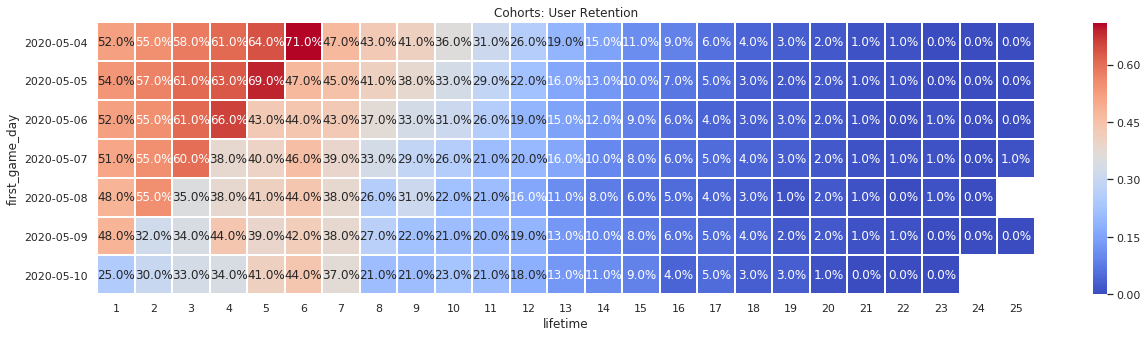

In [31]:
# Построим тепловую карту:
sns.set(style='white')
plt.figure(figsize=(21, 5))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, cmap= 'coolwarm');
plt.show()

Вывод: до 6 дня с момента появления первой когорты пользователей во всех когортах наблюдается увеличение возвращаемости пользователей в игру, после чего на протяжении последующих 3-х недель происходит постепенное снижения уровня возвращаемости пользователей в плоть до 0.

In [32]:
# Вычислим день последнего захода в игру:
last_game_day = data_merge3.groupby(['user_id'])['date'].max()
last_game_day.name = 'last_game_day'
display(last_game_day.sample(2))

# Соединим с основной таблицей - data_merge3: 
data_merge3 = data_merge3.join(last_game_day, on='user_id')
display(data_merge3.sample(2))

user_id
967437c4-f1b9-4cc2-982b-5beda9bb9a55   2020-05-23
6f7c00ae-2676-49eb-b90a-b7330433a65c   2020-05-16
Name: last_game_day, dtype: datetime64[ns]

,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source,unique_events,win_status,building_order,finished_stage_1_date,days_to_win,last_game_day
104497,2020-05-06 06:27:47,building,assembly_shop,8a1cbd21-b898-4aee-be95-c38f7a5a28fd,NaN,2020-05-06,2020-05-06,facebook_ads,[building],not_win,assembly_shop spaceport,NaT,NaN,2020-05-09
67243,2020-05-10 09:44:41,building,research_center,7ad5e2bf-ec19-44c7-a4dc-568fdb829c05,NaN,2020-05-10,2020-05-05,yandex_direct,[building],not_win,assembly_shop spaceport research_center,NaT,NaN,2020-05-13


In [33]:
# Вычислим сколько дней в игре провел игрок:
data_merge3['day_in_game'] = data_merge3['last_game_day'] - data_merge3['first_game_day']

# Проверим на пользователе:
display(data_merge3[data_merge3['user_id']=='7e5e083e-402c-4d43-a7cd-e8a1155c3897'])

,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source,unique_events,win_status,building_order,finished_stage_1_date,days_to_win,last_game_day,day_in_game
28275,2020-05-04 08:54:13,building,assembly_shop,7e5e083e-402c-4d43-a7cd-e8a1155c3897,NaN,2020-05-04,2020-05-04,youtube_channel_reklama,[building],not_win,assembly_shop research_center spaceport,NaT,NaN,2020-05-17,13 days
28276,2020-05-04 23:32:25,building,assembly_shop,7e5e083e-402c-4d43-a7cd-e8a1155c3897,NaN,2020-05-04,2020-05-04,youtube_channel_reklama,[building],not_win,assembly_shop research_center spaceport,NaT,NaN,2020-05-17,13 days
28277,2020-05-05 17:34:26,building,assembly_shop,7e5e083e-402c-4d43-a7cd-e8a1155c3897,NaN,2020-05-05,2020-05-04,youtube_channel_reklama,[building],not_win,assembly_shop research_center spaceport,NaT,NaN,2020-05-17,13 days
28278,2020-05-06 02:16:43,building,assembly_shop,7e5e083e-402c-4d43-a7cd-e8a1155c3897,NaN,2020-05-06,2020-05-04,youtube_channel_reklama,[building],not_win,assembly_shop research_center spaceport,NaT,NaN,2020-05-17,13 days
28279,2020-05-06 19:35:17,building,assembly_shop,7e5e083e-402c-4d43-a7cd-e8a1155c3897,NaN,2020-05-06,2020-05-04,youtube_channel_reklama,[building],not_win,assembly_shop research_center spaceport,NaT,NaN,2020-05-17,13 days
28280,2020-05-08 08:13:00,building,assembly_shop,7e5e083e-402c-4d43-a7cd-e8a1155c3897,NaN,2020-05-08,2020-05-04,youtube_channel_reklama,[building],not_win,assembly_shop research_center spaceport,NaT,NaN,2020-05-17,13 days
28281,2020-05-10 10:54:25,building,assembly_shop,7e5e083e-402c-4d43-a7cd-e8a1155c3897,NaN,2020-05-10,2020-05-04,youtube_channel_reklama,[building],not_win,assembly_shop research_center spaceport,NaT,NaN,2020-05-17,13 days
28282,2020-05-10 21:35:16,building,research_center,7e5e083e-402c-4d43-a7cd-e8a1155c3897,NaN,2020-05-10,2020-05-04,youtube_channel_reklama,[building],not_win,assembly_shop research_center spaceport,NaT,NaN,2020-05-17,13 days
28283,2020-05-12 16:03:49,building,research_center,7e5e083e-402c-4d43-a7cd-e8a1155c3897,NaN,2020-05-12,2020-05-04,youtube_channel_reklama,[building],not_win,assembly_shop research_center spaceport,NaT,NaN,2020-05-17,13 days
28284,2020-05-14 20:49:45,building,spaceport,7e5e083e-402c-4d43-a7cd-e8a1155c3897,NaN,2020-05-14,2020-05-04,youtube_channel_reklama,[building],not_win,assembly_shop research_center spaceport,NaT,NaN,2020-05-17,13 days


### Расчет количества дней проведенных пользователем в игре:

win_status,day_in_game,enemy_defeated,not_win,project_win
0,0 days,3.0,114.0,NaN
1,1 days,43.0,149.0,NaN
2,2 days,102.0,468.0,NaN
3,3 days,186.0,770.0,NaN
4,4 days,418.0,1430.0,NaN
5,5 days,691.0,2370.0,27.0
6,6 days,1436.0,3766.0,121.0
7,7 days,2515.0,4085.0,282.0
8,8 days,3248.0,5280.0,876.0
9,9 days,3923.0,6508.0,1530.0


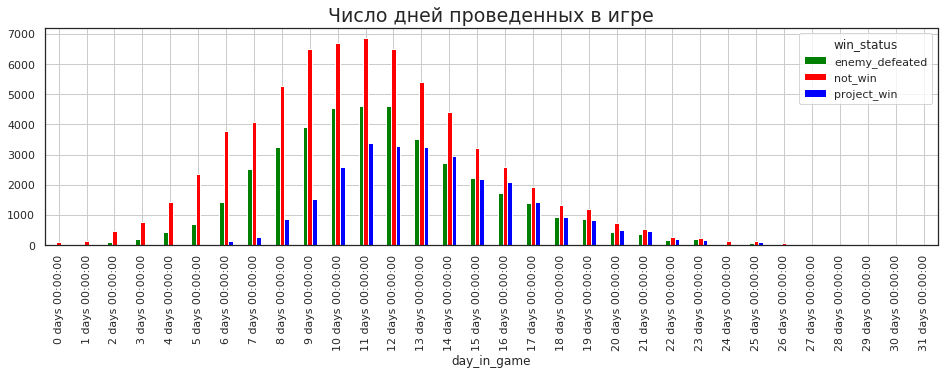

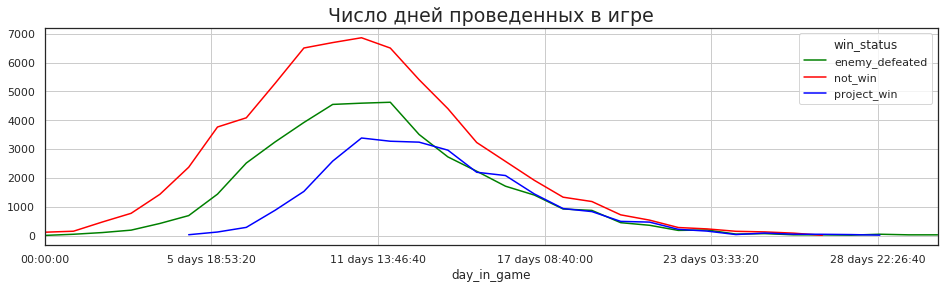

In [34]:
# Построим графики - количества дней которые пользователь провел в игре:

# Построим сводную таблицу:
days_in_g = data_merge3.pivot_table(index='day_in_game', columns='win_status', values='user_id', aggfunc='count').reset_index()
display(days_in_g)

# Построим графики:
ax = days_in_g.plot.bar(figsize=(16,4), color=['green', 'red', 'blue'], x='day_in_game', grid=True)
plt.title('Число дней проведенных в игре', fontsize=19)
plt.show()
ax = days_in_g.plot.line(figsize=(16,4), color=['green', 'red', 'blue'], x='day_in_game', grid=True)
plt.title('Число дней проведенных в игре', fontsize=19)
plt.show()

Вывод: Наибольшее число дней в игре проводят пользователи, не достигшие первого уровня.

Рассчитаем суммарную стоимость кликов по дням

source,facebook_ads,instagram_new_adverts,yandex_direct,youtube_channel_reklama
day,,,,
2020-05-03,935.882786,943.204717,969.139394,454.224943
2020-05-04,548.354480,502.925451,554.651494,259.073224
2020-05-05,260.185754,313.970984,308.232990,147.041741
2020-05-06,177.982200,173.071145,180.917099,88.506074
2020-05-07,111.766796,109.915254,114.429338,55.740645
2020-05-08,68.009276,71.578739,62.961630,40.217907
2020-05-09,38.723350,46.775400,42.779505,23.314669


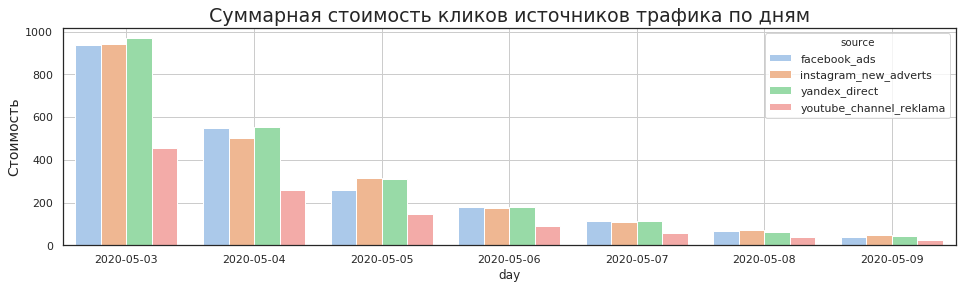

In [35]:
# Рассмотрим датасет - ad_costs и построим столбчатую диаграмму расходов по источникам за период:

# Будем использовать копию таблицы, т.к. нужно будет заменить тип даты на str ниже:
bar_ad_costs = ad_costs.copy()

rotate = bar_ad_costs.pivot_table(index='source', columns='day', values='cost', aggfunc='sum')
# Развернем таблицу для удобного отображения:
display(rotate.transpose())

# Для отображения на оси x только даты прееобразуем в тип - str:
bar_ad_costs['day'] = bar_ad_costs['day'].astype('str')

#Строим график:
plt.figure(figsize=(16,4))
sns.barplot(data = bar_ad_costs, x='day', y='cost', hue='source',palette="pastel")
plt.title('Суммарная стоимость кликов источников трафика по дням', fontsize=19)
plt.ylabel("Стоимость", size=14)
plt.grid(True)
plt.show()

Вывод: Суммарная стоимость кликов в первый день привлечения пользователей максимально за весь период и составляет около 900 на каждый источник за исключением youtube_chanel - который в двое меньше и составляет около 454. Далее каждый день наблюдается снижение суммарной стоимости кликов, но пропорции сохраняются на всем периоде

### Расчет доли пользвателей, пришедших с сразных источников.

,source,user_id
0,facebook_ads,2726
1,instagram_new_adverts,3347
2,yandex_direct,4817
3,youtube_channel_reklama,2686


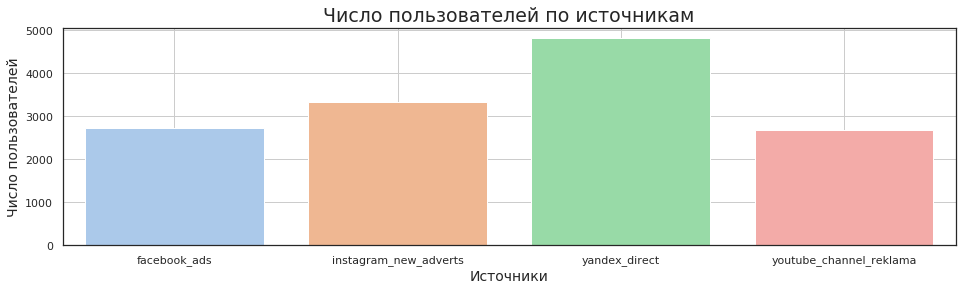

In [36]:
# Построим столбчатую диаграмму количество пользователей по источникам за период:

# Сводная таблица:
us_sor_group = user_source.groupby('source')['user_id'].count().reset_index()
display(us_sor_group)

# Строим график:
plt.figure(figsize=(16,4))
sns.barplot(data=us_sor_group, x='source', y='user_id', palette="pastel")
plt.title('Число пользователей по источникам', fontsize=19)
plt.ylabel("Число пользователей", size=14)
plt.xlabel("Источники", size=14)
plt.grid(True)
plt.show()

Вывод: Наибольшее числопользователей было привлечено с источника - yandex_direct - 4800. Оставшиеся исчтоники привлекли около 3000 пользователей каждый.

win_status,source,enemy_defeated,not_win,project_win
0,facebook_ads,7157,14028,4946
1,instagram_new_adverts,9306,16437,6072
2,yandex_direct,13332,23891,7809
3,youtube_channel_reklama,7390,12814,4774


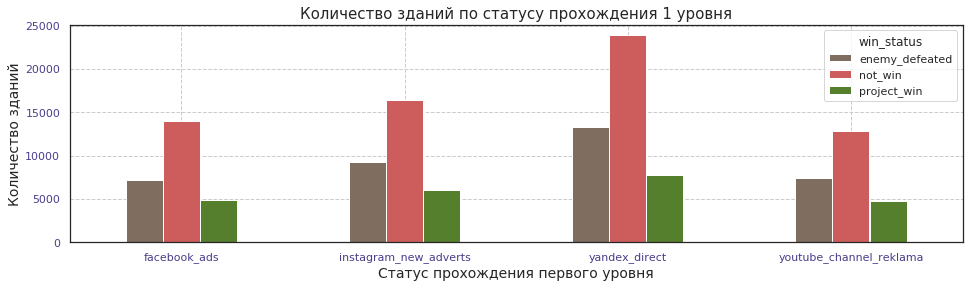

In [37]:
# Посмотрим как источник трафика влияет на статус прохождения 1 уровня:
win_by_source = data_merge3.pivot_table(index='source', columns='win_status', values='building_type', aggfunc='count').reset_index()
display(win_by_source)

# Построим столбчатую диаграмму:
ax = win_by_source.plot.bar(figsize=(16,4), color=['#7f6d5f', '#CD5C5C', '#557f2d'], x='source', grid=True)

plt.title("Количество зданий по статусу прохождения 1 уровня", size=15)
plt.ylabel("Количество зданий", size=14)
plt.yticks(color='#483D8B')
plt.xlabel("Статус прохождения первого уровня", size=14)
plt.xticks(color='#483D8B', rotation='horizontal')
plt.grid(True, linestyle=('--'))
plt.show()

Вывод: Пропорции распределения количества построенных объектов по статусу прохождения первого уровня схожа по всем источникам трафика.

win_status,enemy_defeated,not_win,project_win
source,,,
facebook_ads,7157,14028,4946
instagram_new_adverts,9306,16437,6072
yandex_direct,13332,23891,7809
youtube_channel_reklama,7390,12814,4774


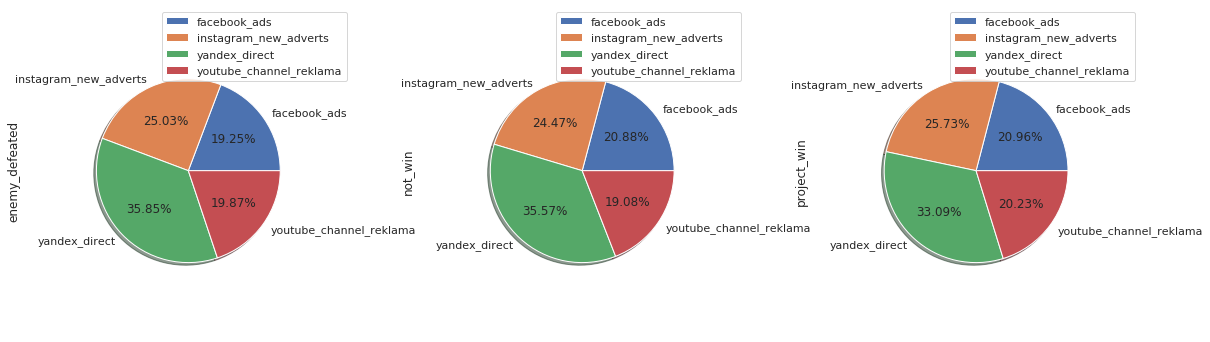

In [38]:
# Отобразим пропорции на круговых диаграммах:
win_by_source_pie = data_merge3.pivot_table(index='source', columns='win_status', values='building_type', aggfunc='count')
display(win_by_source_pie)
plot = win_by_source_pie.plot.pie(subplots=True, figsize=(20, 7), radius=0.7, autopct='%1.2f%%', shadow = True)
plt.show()

## Построение модели монетизации

### 1. Выберем событие после которого будет показ рекламы (или несколько событий)

In [40]:
# По умолчанию выберем показ рекламы на экране постройки здания:

# Для построения модели монетизации возьмем только строки датафрейма у которых событие 'event' == 'building':
model_data = data_merge3[data_merge3['event'] == 'building']
model_data.sample(1)

,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source,unique_events,win_status,building_order,finished_stage_1_date,days_to_win,last_game_day,day_in_game
35795,2020-05-09 07:07:12,building,spaceport,5cd13448-ba50-498f-8a27-c80b70562585,NaN,2020-05-09,2020-05-04,youtube_channel_reklama,"[building, project, finished_stage_1]",project_win,assembly_shop spaceport research_center,2020-05-22,18.0,2020-05-22,18 days


In [41]:
# Найдем количество построенных зданий у каждого игрока:

buildings_count = model_data.groupby('user_id')['building_type'].count().reset_index()
buildings_count = buildings_count.rename(columns={'building_type':'total_building'})
#display(buildings_count)

# Будем показывать рекламу на каждое 3-ю постройку здания:
# 'shows_ad' - количество показов рекламы:
buildings_count['shows_ad'] = np.floor(buildings_count['total_building'] / 3).astype('int')
display(buildings_count)

,user_id,total_building,shows_ad
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13,4
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9,3
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4,1
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8,2
4,002f508f-67b6-479f-814b-b05f00d4e995,12,4
...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,9,3
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,16,5
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,9,3
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,7,2


Вывод: Мы не знаем время постройки зданий, но если пользователю показывать рекламу чаще(каждый раз при постройке здания), то вероятность того, что он перестанет играть увеличится.

### Вычисление CAC:

In [42]:
# Вычислим суммарные затраты на каждый источник:
cost_by_source = ad_costs.groupby('source')['cost'].sum().reset_index()
display(cost_by_source)

# Посчитаем количество пришедших пользователей по каждому источнику:
user_by_source = user_source.groupby('source')['user_id'].count().reset_index()
user_by_source = user_by_source.rename(columns={'user_id':'count_users'})
display(user_by_source)

# Соединим эти таблицы по источнику - source:
cac_by_source = pd.merge(cost_by_source, user_by_source, on='source')

# Рассчитаем cac:
cac_by_source['cac'] = (cac_by_source['cost'] / cac_by_source['count_users']).round(3)
display(cac_by_source)

,source,cost
0,facebook_ads,2140.904643
1,instagram_new_adverts,2161.441691
2,yandex_direct,2233.111449
3,youtube_channel_reklama,1068.119204


,source,count_users
0,facebook_ads,2726
1,instagram_new_adverts,3347
2,yandex_direct,4817
3,youtube_channel_reklama,2686


,source,cost,count_users,cac
0,facebook_ads,2140.904643,2726,0.785
1,instagram_new_adverts,2161.441691,3347,0.646
2,yandex_direct,2233.111449,4817,0.464
3,youtube_channel_reklama,1068.119204,2686,0.398


### Посчитать примерное количество рекламы, которое сможем показать

In [43]:
# Соединим таблицы buildings_count и user_source для соотнесения источника каждому пользователю:
user_source_data = buildings_count.merge(user_source, on='user_id')
display(user_source_data)

,user_id,total_building,shows_ad,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13,4,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9,3,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4,1,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8,2,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,12,4,facebook_ads
...,...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,9,3,instagram_new_adverts
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,16,5,facebook_ads
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,9,3,yandex_direct
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,7,2,instagram_new_adverts


### Подсчитаем какая у одного показа должна быть стоимость, чтобы выйти в 0

In [44]:
# Соединяемые таблицы:
display(user_source_data.head(2))
display(cac_by_source.head(2))

# Соединим таблицы user_source_data и cac_by_source для соотнесения среднего значения cac по источнику каждому пользователю:
ddd = user_source_data.merge(cac_by_source, on='source')
display(ddd)

,user_id,total_building,shows_ad,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13,4,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9,3,yandex_direct


,source,cost,count_users,cac
0,facebook_ads,2140.904643,2726,0.785
1,instagram_new_adverts,2161.441691,3347,0.646


,user_id,total_building,shows_ad,source,cost,count_users,cac
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13,4,facebook_ads,2140.904643,2726,0.785
1,002f508f-67b6-479f-814b-b05f00d4e995,12,4,facebook_ads,2140.904643,2726,0.785
2,004074f8-251a-4776-922c-8348dca1a2f6,12,4,facebook_ads,2140.904643,2726,0.785
3,00440efd-aa50-4b4b-aae8-ffcd1782729d,7,2,facebook_ads,2140.904643,2726,0.785
4,00965328-5e54-453f-b11b-52f8ae9ae80b,8,2,facebook_ads,2140.904643,2726,0.785
...,...,...,...,...,...,...,...
13571,ffb5af93-7ab2-4020-b66b-06d3ec69bbb9,8,2,instagram_new_adverts,2161.441691,3347,0.646
13572,ffb79d1c-e3ab-4702-918d-e14aba0835a3,3,1,instagram_new_adverts,2161.441691,3347,0.646
13573,ffc6f4fa-3476-47af-85cb-e2ee0551110a,13,4,instagram_new_adverts,2161.441691,3347,0.646
13574,ffef4fed-164c-40e1-bde1-3980f76d0fb5,9,3,instagram_new_adverts,2161.441691,3347,0.646


In [45]:
# Рассчитаем стоимость показа рекламы - ad_serving_cost:
# Учтем отток пользователей после первого показа рекламы - домножим числопостроенных зданий - 'total_building' на коэф. 0.9.
ddd['total_building'] = ddd['total_building'] * 0.9

# рассчитаем стоимость показа рекламы:
ddd['ad_serving_cost'] = ddd['cac'] / ddd['total_building']
ddd['ad_serving_cost'] = ddd['ad_serving_cost'].round(3)
display(ddd)

# рассчитаем среднюю стоимость показа рекламы:
display("Средняя стоимость 1 показа рекламы: " + str(ddd['ad_serving_cost'].mean()))

,user_id,total_building,shows_ad,source,cost,count_users,cac,ad_serving_cost
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,11.7,4,facebook_ads,2140.904643,2726,0.785,0.067
1,002f508f-67b6-479f-814b-b05f00d4e995,10.8,4,facebook_ads,2140.904643,2726,0.785,0.073
2,004074f8-251a-4776-922c-8348dca1a2f6,10.8,4,facebook_ads,2140.904643,2726,0.785,0.073
3,00440efd-aa50-4b4b-aae8-ffcd1782729d,6.3,2,facebook_ads,2140.904643,2726,0.785,0.125
4,00965328-5e54-453f-b11b-52f8ae9ae80b,7.2,2,facebook_ads,2140.904643,2726,0.785,0.109
...,...,...,...,...,...,...,...,...
13571,ffb5af93-7ab2-4020-b66b-06d3ec69bbb9,7.2,2,instagram_new_adverts,2161.441691,3347,0.646,0.090
13572,ffb79d1c-e3ab-4702-918d-e14aba0835a3,2.7,1,instagram_new_adverts,2161.441691,3347,0.646,0.239
13573,ffc6f4fa-3476-47af-85cb-e2ee0551110a,11.7,4,instagram_new_adverts,2161.441691,3347,0.646,0.055
13574,ffef4fed-164c-40e1-bde1-3980f76d0fb5,8.1,3,instagram_new_adverts,2161.441691,3347,0.646,0.080


'Средняя стоимость 1 показа рекламы: 0.0857024160282852'

Вывод: Стоимость 1 показа рекламы увеличилась до 0.085

## Проверка гипотез

### Проверьте гипотезу различия времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком.

Сформируем гипотезы:
- Нулевая гипотеза: средние значения времени (дни) прохождения уровня между пользователями, которые завершили уровень через реализацию проекта (Группа A) и пользователями, которые завершили уровень победой над другим игроком (Группа B) - равны.

- Альтернативная гипотеза: средние значения времени (дни) прохождения уровня между пользователями, которые завершили уровень через реализацию проекта (Группа A) и пользователями, которые завершили уровень победой над другим игроком (Группа B) - различаются.

In [46]:
# Выберем из общего дата фрейма пользователей которые завершили 1 уровень с помощью проекта и победой над врагом соответственно:
winners_by_project_data = data_merge3[data_merge3['win_status'] == 'project_win']
winners_by_enemy_defeated_data = data_merge3[data_merge3['win_status'] == 'enemy_defeated']

display(winners_by_project_data.sample(2))
display(winners_by_enemy_defeated_data.sample(2))

# Сгруппируем датасеты по пользователю с аггрегирующей функцией - first(первое значение) количества дней о победы ('days_to_win'):
winners_by_project = winners_by_project_data.groupby('user_id')['days_to_win'].first().reset_index()
winners_by_enemy_defeated = winners_by_enemy_defeated_data.groupby('user_id')['days_to_win'].first().reset_index()

display(winners_by_project.sample(2))
display(winners_by_enemy_defeated.sample(2))

,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source,unique_events,win_status,building_order,finished_stage_1_date,days_to_win,last_game_day,day_in_game
59206,2020-05-09 12:41:12,building,research_center,fdbbb342-90b2-41fa-8253-24b3a28356ff,NaN,2020-05-09,2020-05-04,yandex_direct,"[building, project, finished_stage_1]",project_win,assembly_shop spaceport research_center,2020-05-13,9.0,2020-05-13,9 days
100329,2020-05-13 22:15:49,building,spaceport,58b51ed4-e6e0-44a3-92f5-38f39b873359,NaN,2020-05-13,2020-05-06,facebook_ads,"[building, project, finished_stage_1]",project_win,assembly_shop spaceport research_center,2020-05-23,17.0,2020-05-23,17 days


,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source,unique_events,win_status,building_order,finished_stage_1_date,days_to_win,last_game_day,day_in_game
97330,2020-05-12 15:41:05,building,spaceport,257480f9-5b71-440f-8b20-a1dc430515bc,NaN,2020-05-12,2020-05-05,instagram_new_adverts,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport research_center,2020-05-22,17.0,2020-05-22,17 days
81408,2020-05-07 21:05:04,building,assembly_shop,5a04757e-267d-4530-ad45-af807bde3102,NaN,2020-05-07,2020-05-05,instagram_new_adverts,"[building, finished_stage_1]",enemy_defeated,assembly_shop spaceport,2020-05-14,9.0,2020-05-14,9 days


,user_id,days_to_win
391,32749dd2-47f9-4cb7-ac89-cfa0113fc30d,13.0
407,34ce7ea2-6889-4af2-9b57-81f11ef336b6,16.0


,user_id,days_to_win
2271,9435e74e-247d-4664-9bca-516ee42347d2,9.0
757,2e66b9f2-cfad-4f1e-b5e6-87670f483b16,8.0


In [47]:
# Выберем столбцы с числом дней до победы:
winners_by_project = winners_by_project['days_to_win']
display(winners_by_project)

winners_by_enemy_defeated = winners_by_enemy_defeated['days_to_win']
display(winners_by_enemy_defeated)

0       12.0
1       16.0
2       20.0
3       14.0
4       15.0
        ... 
1861    19.0
1862     8.0
1863    14.0
1864    11.0
1865    17.0
Name: days_to_win, Length: 1866, dtype: float64

0        7.0
1       12.0
2       12.0
3       11.0
4        6.0
        ... 
3946    11.0
3947    13.0
3948    14.0
3949     7.0
3950     8.0
Name: days_to_win, Length: 3951, dtype: float64

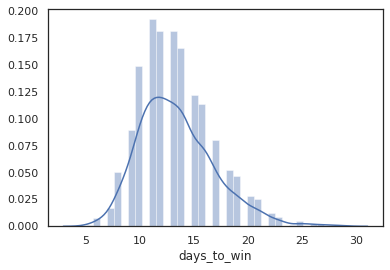

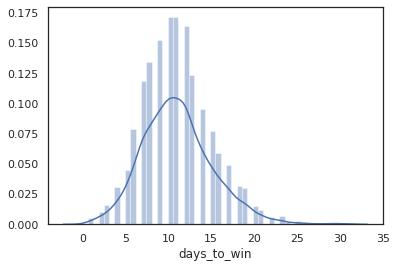

In [48]:
# Проверим распределения на нормальность:

# Построим гистограммы распределения выборок:
sns.distplot(winners_by_project)
plt.show()
sns.distplot(winners_by_enemy_defeated)
plt.show()

Проверим нормальность распределения с помощью критерия - Шапиро-Уилка:
- H0: средние значения времени (дни) прохождения уровня между пользователями, которые завершили уровень через реализацию проекта (Группа A) и пользователями, которые завершили уровень победой над другим игроком (Группа B) - распределены нормально.

- H0: средние значения времени (дни) прохождения уровня между пользователями, которые завершили уровень через реализацию проекта (Группа A) и пользователями, которые завершили уровень победой над другим игроком (Группа B) - распределены ненормально.

In [49]:
#Задаем критический уровень статистической значимости:
alpha = 0.05

display(st.shapiro(winners_by_project))
display(st.shapiro(winners_by_enemy_defeated))

(0.9618321657180786, 9.22034863383936e-22)

(0.9774916768074036, 1.539442926661853e-24)

Вывод: На гистограммах распределение похоже - хи-квадрат. При проверке распределения на нормальность с помощью критерия Шапиро_Уилка p_value меньше чем alpha = 0.05  в обоих выборках. Распределение не нормально.

Для проверки гипотез используем тест Манна-Уитни он подходит для выборок, которые распределены ненормально:

In [50]:
# Проводим тест Манна-Уитни:
#Задаем критический уровень статистической значимости:
alpha = 0.05

results = st.mannwhitneyu(winners_by_project, winners_by_enemy_defeated, alternative = "two-sided")

# Распечатаем p_value:
display('p-значение: ' + str(results.pvalue))

if results.pvalue < alpha:
    display("Отвергаем нулевую гипотезу.")
else:
    display("Не получилось отвергнуть нулевую гипотезу.")

'p-значение: 4.786610358453673e-105'

'Отвергаем нулевую гипотезу.'

Вывод: p_value меньше alpha. Отвергаем нулевую гипотезу. Средние значения времени (дни) прохождения уровня между пользователями, которые завершили уровень через реализацию проекта (Группа A) и пользователями, которые завершили уровень победой над другим игроком (Группа B) - различаются.

### Сформулируйте и проверьте статистическую гипотезу относительно представленных данных.

Сформируем гипотезы (односторонняя проверка:):

- Нулевая гипотеза: среднее значение числа построенных зданий пользователями, прошедших 1 уровень победой над врагом и пользователями прошедших 1 уровень реализацией проекта равны.
- Альтернативная гипотеза: среднее значение числа построенных зданий пользователями, прошедших 1 уровень победой над врагом больше среднего значение числа построенных зданий пользователями прошедших 1 уровень реализацией проекта.

In [51]:
display(data_merge3.sample(2))

,event_datetime,event,building_type,user_id,project_type,date,first_game_day,source,unique_events,win_status,building_order,finished_stage_1_date,days_to_win,last_game_day,day_in_game
134287,2020-05-19 07:55:09,building,spaceport,f031f0fe-213d-4f12-8f21-408f1a29af55,NaN,2020-05-19,2020-05-10,yandex_direct,[building],not_win,assembly_shop spaceport,NaT,NaN,2020-05-19,9 days
119490,2020-05-15 21:59:34,building,spaceport,186aed71-e2ed-495f-8784-ba890ecb3103,NaN,2020-05-15,2020-05-07,yandex_direct,"[building, project, finished_stage_1]",project_win,assembly_shop spaceport research_center,2020-05-19,12.0,2020-05-19,12 days


In [52]:
# Сформируем выборки для проверки гипотез:
buildings_by_project = winners_by_project_data.groupby('user_id')['building_type'].count()
display(buildings_by_project)

buildings_by_enemy_defeated = winners_by_enemy_defeated_data.groupby('user_id')['building_type'].count()
display(buildings_by_enemy_defeated)

user_id
006380d6-67a6-45de-ab1e-6eb54ad8dbe8    11
00be7371-fa79-4fbd-b8e7-8ba32e3f8f82    12
00c2b9f2-2615-439c-aed0-6974e4c6c1c1    11
00de2809-403e-4476-a2f7-ca1b11700190    13
00e83261-5fd4-4939-9616-802b5a0202c6    13
                                        ..
ff50f63a-c4b3-494e-8bf9-3f19dbfc513e    18
ff60fcd1-4329-494e-b82d-461fbdf5b5eb    11
ff83bdd8-f49a-49fd-8aad-9fa1fb30d516    13
ff841992-d93b-462e-bc6e-18c24a514f36    20
ffff69cc-fec1-4fd3-9f98-93be1112a6b8    12
Name: building_type, Length: 1866, dtype: int64

user_id
001d39dc-366c-4021-9604-6a3b9ff01e25     8
003ee7e8-6356-4286-a715-62f22a18d2a1     8
004074f8-251a-4776-922c-8348dca1a2f6    12
00464e5e-28ed-4be6-bf44-517ef7b3937b     8
0056c007-c082-43cc-bdef-afc49bca4cb9     3
                                        ..
ffc6f4fa-3476-47af-85cb-e2ee0551110a    13
ffd002f3-3545-423e-8dba-0c6a2d48a3aa     7
ffe810f4-1a1f-464b-924d-6f120b0cb8df    16
ffef4fed-164c-40e1-bde1-3980f76d0fb5     9
fffb626c-5ab6-47c9-8113-2062a2f18494     9
Name: building_type, Length: 3951, dtype: int64

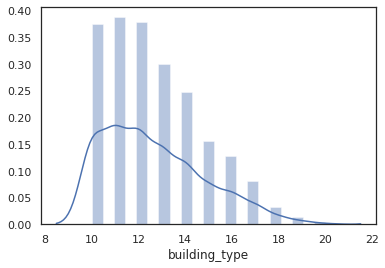

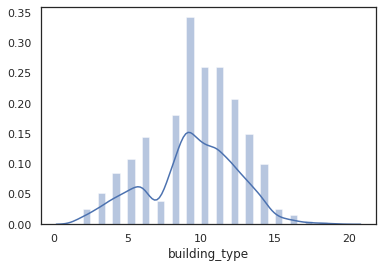

In [53]:
# Проверим распределения на нормальность:

# Построим гистограммы распределения выборок:
sns.distplot(buildings_by_project)
plt.show()
sns.distplot(buildings_by_enemy_defeated)
plt.show()

Вывод: Распределение на выборках ненормально. Для проверки гипотез используем тест Манна-Уитни:

In [54]:
#Задаем критический уровень статистической значимости:
alpha = 0.05

results = st.mannwhitneyu(buildings_by_project, buildings_by_enemy_defeated, alternative = "greater")

# Распечатаем p_value:
display('p-значение: ' + str(results.pvalue))

if results.pvalue < alpha:
    display("Отвергаем нулевую гипотезу.")
else:
    display("Не получилось отвергнуть нулевую гипотезу.")

'p-значение: 2.605963137511153e-305'

'Отвергаем нулевую гипотезу.'

Вывод: p_value - около нуля, отвергаем нулевую гипотезу, среднее значение числа построенных зданий выборок не равны. среднее значение числа построенных зданий пользователями, прошедших 1 уровень победой над врагом больше среднего значение числа построенных зданий пользователями прошедших 1 уровень реализацией проекта.

Рассчитаем число зданий которые строит пользователь в зависимости от статуса победы

In [55]:
# Сгруппируем датасет по статусу прохождения 1 уровня('win_status') и пользователю с подсчетом количества построенных зданий:
data_merge3_groupby = data_merge3.groupby(['win_status','user_id'])['building_type'].count().reset_index()

# Затем полученный датасет сгруппируем по 'win_status' с подсчетом количества пользователей и суммированием количества
#построенных зданий:
group_users_buildings = data_merge3_groupby.groupby('win_status').agg({'user_id':'count', 'building_type':'sum'}).reset_index()

# Посчитаем количество построенных зданий на пользователя:
group_users_buildings['ratio'] = group_users_buildings['building_type'] / group_users_buildings['user_id']
display(group_users_buildings)

,win_status,user_id,building_type,ratio
0,enemy_defeated,3951,37185,9.411541
1,not_win,7759,67170,8.657043
2,project_win,1866,23601,12.647910


Вывод:  Пользователеи завершившие 1 уровень - реализацией проекта строят больше зданий 12,6 против 9,4 на пользователя завершивших 1 уровень победой над игроком.

Итоговый вывод:
    
- 43% - Игроков завершили 1 уровень.
- От 7 до 16 дней требуется игрокам для победы. 
- Среднее число дней для прохождения 1 уровня способом победы над врагом и реализацией проекта составляет 11,6 и 13.4 соответственно.
- 'assembly_shop – spaceport - research_center – Наиболее часто встречающаяся последовательность постройки у игроков.
- Источник привлечения пользователей не оказывает влияния на % игроков, завершивших 1 уровень
- Пропорции строящихся зданий по типу не отличаются для всех статусов прохождения 1 уровня
- До 6 дня с момента появления первой когорты пользователей во всех когортах наблюдается увеличение возвращаемости пользователей в игру, после чего на протяжении последующих 3-х недель происходит постепенное снижения уровня возвращаемости пользователей в плоть до 0.
- В течении 30 дней пользователи покидаю проект
- Реклама будет показана каждый 3-й раз на экране постройки объекта.
- Реклама будет реализована в виде баннера или видео ролика продолжительностью не более 20 секунд.
- Стоимость показа рекламы составила для достижения уровня окупаемости составляет 0,085
- Нулевая гипотеза: средние значения времени (дни) прохождения уровня между пользователями, которые завершили уровень через реализацию проекта и пользователями, которые завершили уровень победой над другим игроком - равны. Была отвергнута.
- Нулевая гипотеза: среднее значение числа построенных зданий пользователями, прошедших 1 уровень победой над врагом и пользователями прошедших 1 уровень реализацией проекта равны. Была отвергнута